In [184]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [185]:
#load the dataset and check the head
train = pd.read_csv('titanic/train.csv')

In [186]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Initial Data Exploration

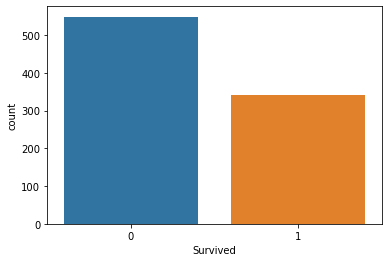

In [187]:
sns.countplot(x='Survived', data=train)

In [188]:
#explore relations between sex and survival
train.groupby('Sex')[['Survived']].count()

,Survived
Sex,
female,314
male,577


In [189]:
train.groupby('Sex')[['Survived']].mean()

,Survived
Sex,
female,0.742038
male,0.188908


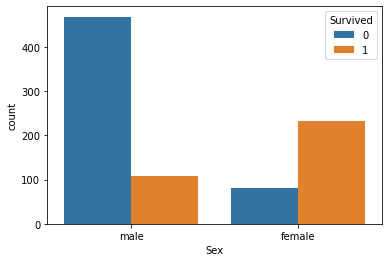

In [190]:
sns.countplot(x='Sex', hue='Survived', data=train)

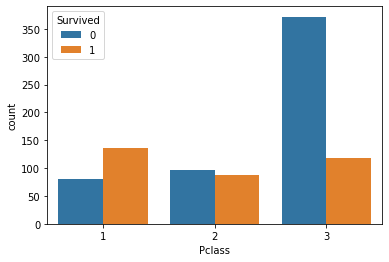

In [101]:
#explore relations between PClass and survival
sns.countplot(x='Pclass', hue='Survived', data=train)

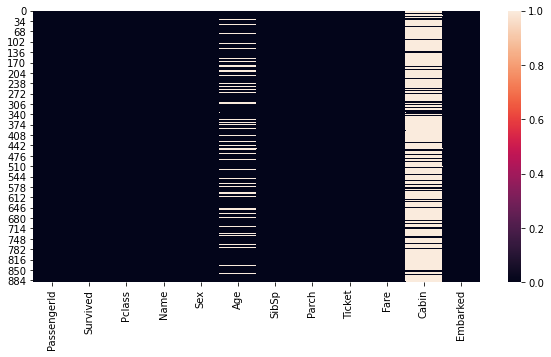

In [102]:
#check for NA values
plt.figure(figsize=(10,5))
sns.heatmap(train.isna())

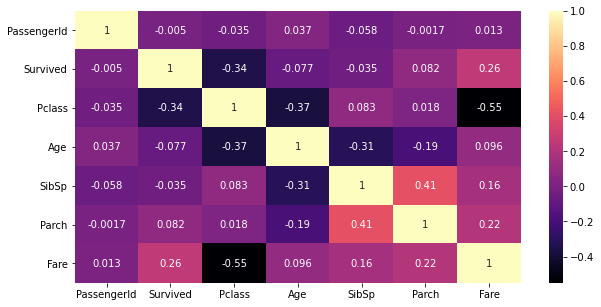

In [103]:
#check correlation through heatmap
plt.figure(figsize=(10,5))
sns.heatmap(train.corr(), cmap='magma', annot=True)

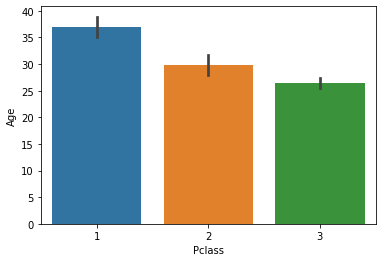

In [126]:
#check age by class
sns.barplot(x='Pclass', y='Age', data=train)

In [127]:
train.groupby('Pclass')[['Age']].mean()

,Age
Pclass,
1,37.048118
2,29.866958
3,26.403259


# Data Cleaning

In [104]:
#remove columns that can't be used
train.drop(['Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

In [105]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [106]:
sex_dummies = pd.get_dummies(train['Sex'])
sex_dummies

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [107]:
train = pd.concat([train, sex_dummies], axis=1)

In [108]:
embarked_dummies = pd.get_dummies(train['Embarked'])

In [109]:
train = pd.concat([train, embarked_dummies], axis=1)

In [110]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,female,male,C,Q,S
0,1,0,3,male,22.0,1,0,7.2500,S,0,1,0,0,1
1,2,1,1,female,38.0,1,0,71.2833,C,1,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,1,0,0,0,1
3,4,1,1,female,35.0,1,0,53.1000,S,1,0,0,0,1
4,5,0,3,male,35.0,0,0,8.0500,S,0,1,0,0,1


In [111]:
#even though it doesn't apply to random forests, remove multicollinearity issues for good practice
train.drop(['male', 'C'], axis=1, inplace=True)

In [112]:
#drop columns that dummies were made for
train.drop(['Sex', 'Embarked'], axis=1, inplace=True)

In [113]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,female,Q,S
0,1,0,3,22.0,1,0,7.2500,0,0,1
1,2,1,1,38.0,1,0,71.2833,1,0,0
2,3,1,3,26.0,0,0,7.9250,1,0,1
3,4,1,1,35.0,1,0,53.1000,1,0,1
4,5,0,3,35.0,0,0,8.0500,0,0,1


In [130]:
#from earlier, we found the average age for each PClass
#so we can fill the n/a ages based on class
def fill_age(columns):
    
    age = columns[0]
    pclass = columns[1]
    
    if pd.isnull(age):
        if pclass == 1:
            return 37
        elif pclass == 2:
            return 29
        else:
            return 26
    else:
        return age

In [131]:
train['Age'] = train[['Age', 'Pclass']].apply(fill_age, axis=1)

In [132]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Age            0
SibSp          0
Parch          0
Fare           0
female         0
Q              0
S              0
dtype: int64

# Model Fitting

In [143]:
## split the data
from sklearn.model_selection import train_test_split

In [144]:
x = train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'female', 'Q', 'S']]
y = train['Survived']

In [145]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2)

In [146]:
from sklearn.ensemble import RandomForestClassifier

In [177]:
#create and fit the random forest. Since the dataset isn't too large, use n_estimators=100
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')

In [178]:
rf.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy')

In [179]:
#check the score of our random forest
print(rf.score(x_train, y_train))

0.9845505617977528


In [180]:
preds = rf.predict(x_test)

In [181]:
from sklearn.metrics import classification_report

In [182]:
#find the accuracy on the test set
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       107
           1       0.83      0.75      0.79        72

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

